In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [ ]:
# Define variables
all_stims = np.hstack(np.array(trial_ts.stim_ts))
post_seconds = 0.15
bin_size = 0.010  # 10ms bins
start_time = all_stims[0]
end_time = all_stims[-1] + post_seconds

# Create time bins
time_bins = np.arange(start_time, end_time + bin_size, bin_size)
combined_bins = np.union1d(time_bins, all_stims)
combined_bins.sort()
time_bins = combined_bins

# Bin spike times for each unit
n_units = len(spike_times_per_unit)
n_bins = len(time_bins) - 1
binned_spike_counts = np.zeros((len(time_bins) - 1, n_units))
for unit_idx, spike_times in enumerate(spike_times_per_unit):
    counts, _ = np.histogram(spike_times, bins=time_bins)
    binned_spike_counts[:, unit_idx] = counts

# Create stimulus indicator vector
stim_indicator = np.zeros(len(time_bins) - 1)
stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
stim_indicator[stim_indices] = 1

# Check that the alignment is correct
tolerance = 1e-6
retrieved_stim_times = time_bins[stim_indices]
time_differences = all_stims - retrieved_stim_times
alignment_check = np.all(np.abs(time_differences) < tolerance)
print(f"All stim_indices align with all_stims within tolerance: {alignment_check}")

if alignment_check:
    # Construct design matrix with time lags
    n_timepoints = 15  # Number of time lags
    design_matrix = np.zeros((n_bins, n_timepoints))

    for lag in range(n_timepoints):
        if lag == 0:
            design_matrix[:, lag] = stim_indicator
        else:
            design_matrix[lag:, lag] = stim_indicator[:-lag]
    print(f"design matrix shape: {design_matrix.shape}\nresponse matrix shape: {binned_spike_counts.shape}")
else:
    print("Alignment issue detected. Please check time_bins and stim_times.")

All stim_indices align with all_stims within tolerance: True
design matrix shape: (456099, 15)
response matrix shape: (456099, 177)


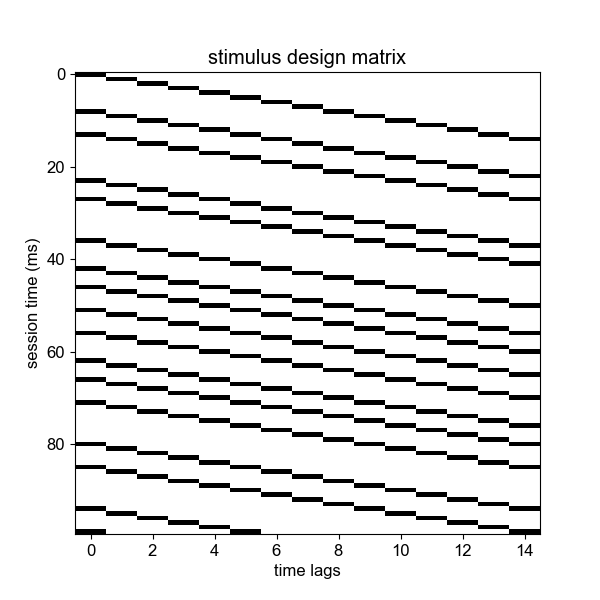

In [30]:
plt.figure(figsize=(6, 6))
plt.imshow(design_matrix[0:100, :], aspect='auto', cmap='gray_r')
plt.xlabel('time lags')
plt.ylabel('session time (ms)')
plt.title('stimulus design matrix')
plt.show()

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = LinearRegression()
X = design_matrix
Y = binned_spike_counts

cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, Y, cv=cv, scoring='r2')
print(scores.mean())

0.0014040627283042387


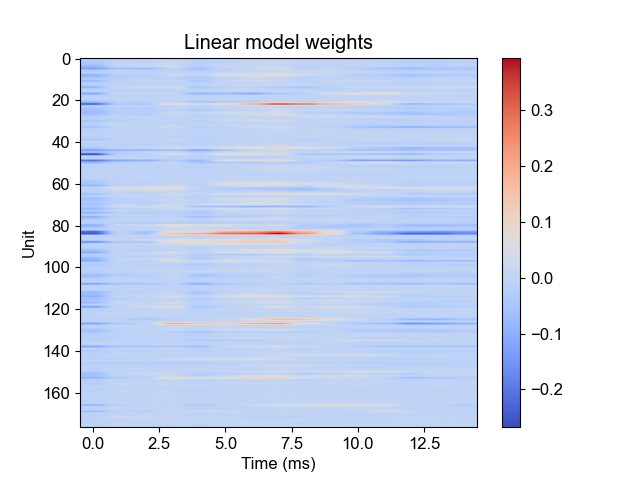

In [33]:
model.fit(X, Y)

plt.figure()
plt.imshow(model.coef_, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Unit')
plt.title('Linear model weights')
plt.show()

In [ ]:
n_units, n_stims, n_timepoints = pop_peth.shape

y = pop_peth.reshape(n_units, n_stims*n_timepoints)

#sklearn expects time to be the first dimension
y = y.T
X = np.tile(np.eye(n_timepoints), (n_stims, 1))

print(X.shape, y.shape)
assert y.shape[0] == X.shape[0]

In [ ]:
X

In [ ]:
#let's implement some cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = LinearRegression()
cv = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
print(scores.mean())

model.fit(X, y)

In [ ]:
plt.figure()
plt.imshow(model.coef_, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (ms)')
plt.ylabel('Unit')
plt.title('Linear model weights')
plt.show()

In [ ]:
# I want to make an interactive line plot of a unit's weight across time
# and also plot the PSTH for each unit to compare the weights with the actual activity

from matplotlib.widgets import Slider, Button
fig, (ax_weights, ax_psth) = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.25, bottom=0.25, wspace=0.4)
axcolor = 'lightgoldenrodyellow'
axunit = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sunit = Slider(axunit, 'Unit', 0, n_units-1, valinit=0, valstep=1)

# Add buttons for navigating units
axprev = plt.axes([0.1, 0.025, 0.1, 0.04])
axnext = plt.axes([0.21, 0.025, 0.1, 0.04])
bprev = Button(axprev, 'Previous')
bnext = Button(axnext, 'Next')

def update(val):
    unit = int(sunit.val)
    ax_weights.clear()
    ax_weights.plot(np.arange(0, 130, 10), model.coef_[unit, :], color='blue')
    ax_weights.set_xlabel('Time (ms)')
    ax_weights.set_ylabel('Weight')
    ax_weights.set_title(f'Unit: {unit} Weights')
    ax_weights.set_xlim(0, 130)

    ax_psth.clear()
    ax_psth.plot(np.arange(0, 130, 10), np.mean(pop_peth[unit, :, :], axis=0), color='green')
    ax_psth.set_xlabel('Time (ms)')
    ax_psth.set_ylabel('sp/s')
    ax_psth.set_title(f'Unit: {unit} PSTH')
    ax_psth.set_xlim(0, 130)

    plt.draw()

def prev(event):
    current_val = sunit.val
    if current_val > 0:
        sunit.set_val(current_val - 1)

def next(event):
    current_val = sunit.val
    if current_val < n_units - 1:
        sunit.set_val(current_val + 1)

sunit.on_changed(update)
bprev.on_clicked(prev)
bnext.on_clicked(next)
update(0)  # Initial plot
plt.show()
